#### Imports

In [4]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)
sys.modules['dostools.src'] = dostools

In [5]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ImportError: cannot import name 'data' from 'dostools.src.datasets' (unknown location)

## Evaluator

In [3]:
import dostools.evaluation.evaluation as evaluation
importlib.reload(evaluation)
import dostools.models.training as training
importlib.reload(training)

targets = {
    'pw' : ldos,
    'lcdf' : y_lcdf,
    'pc' : y_pc
}
evaluator = evaluation.Evaluator(targets, xdos, mean_dos_per_atom)

## Generate data

Data Generation will consist of two steps  
1. Generate a random alignment 
2. Use scikitlearn Ridge to determine optimal loss

In [6]:
### Define limits for alignment to prevent complete shifts (shifting the spectrum out of the data)

def determine_bounds(input_dos, threshold):
    boo_dos = input_dos > threshold
    left_bound = torch.nonzero(boo_dos)[0]
    right_bound = torch.nonzero(boo_dos)[-1]
        
    return (0-left_bound), (788-right_bound)

In [7]:
bounds = []
for i in ldos[train_index]:
    bounds.append(determine_bounds(i, 1e-10))

bounds = torch.tensor(bounds)

In [8]:
bounds

tensor([[ -71,  121],
        [-145,  149],
        [ -28,   22],
        ...,
        [-132,  130],
        [-108,  130],
        [ -69,  104]])

In [9]:
xdos_step = xdos[1] - xdos[0]

In [74]:
from sklearn.linear_model import Ridge
import dostools.src.loss.loss as loss
import dostools.consistency.consistency as consistency
importlib.reload(loss)
importlib.reload(consistency)
#Since it should be alright to overfit shifts
def determine_error(normalized_dos):
    model = Ridge(alpha = 0, fit_intercept = False, solver = 'svd')
    model.fit(Silicon.Features['structure_avekerneldescriptors'][train_index,:], normalized_dos)
    
    preds = model.predict(Silicon.Features['structure_avekerneldescriptors'][train_index,:])
    with torch.no_grad():
        rmse = loss.t_get_rmse(torch.tensor(preds), normalized_dos, xdos)
        
    return rmse
        

def normalize(ldos, alignment):
    shifted_dos = consistency.shifted_ldos(ldos, xdos, alignment * xdos_step)
    mean = torch.mean(shifted_dos, dim = 0)
    normalized_dos = shifted_dos - mean
    
    return normalized_dos

def generate_sample(bounds, ldos, batch_size):
    x_sample = []
    for bound in bounds:
        col_i = torch.randint(bound[0], bound[1], (batch_size,1))
        x_sample.append(col_i)
    
    x_sample = torch.hstack(x_sample)
    
    y_sample = []
    for x in x_sample:
        normalized_dos = normalize(ldos, x)
        y = determine_error(normalized_dos)
        y_sample.append(y)
        
        
    y_sample = torch.tensor(y_sample)
    
    return (x_sample, y_sample)

In [75]:
a_ldos = ldos[train_index]
a_ldos[:100] = consistency.shifted_ldos(a_ldos[:100], xdos, np.zeros(100)-1)

In [76]:
def shifted_ldos(ldos, xdos, shift): 
    xdos_step = xdos[1] - xdos[0]
    shifted_ldos = torch.zeros_like(ldos)
    if len(ldos.shape) > 1:
        xdos_shift = torch.round(shift/xdos_step).int()
        for i in range(len(ldos)):
            if xdos_shift[i] > 0:
                shifted_ldos[i] = torch.nn.functional.pad(ldos[i,:-1*xdos_shift[i]], (xdos_shift[i],0))
            elif xdos_shift[i] < 0:
                shifted_ldos[i] = torch.nn.functional.pad(ldos[i,(-1*xdos_shift[i]):], (0,(-1*xdos_shift[i])))
            else:
                shifted_ldos[i] = ldos[i]
    else:        
        xdos_shift = int(torch.round(shift/xdos_step))
        if xdos_shift > 0:
            print (xdos_shift)
            shifted_ldos = torch.nn.functional.pad(ldos[:-1*xdos_shift], (xdos_shift,0))
            print (shifted_ldos.shape)
        elif xdos_shift < 0:
            shifted_ldos = torch.nn.functional.pad(ldos[(-1*xdos_shift):], (0,(-1*xdos_shift)))
        else:
            shifted_ldos = ldos
    return shifted_ldos

In [77]:
targ = shifted_ldos(y_pw[0], xdos, 10*xdos_step)    


10
torch.Size([778])


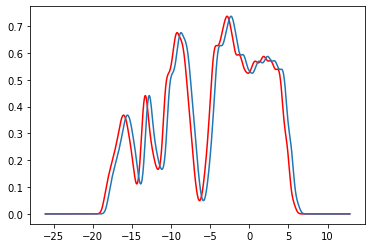

In [85]:
%matplotlib inline
targ = consistency.shifted_ldos(ldos[0], xdos, -10*xdos_step)
plt.plot(xdos, targ, color = 'r')
plt.plot(xdos, ldos[0])

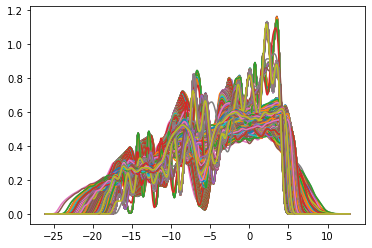

In [118]:
for i in range(0,1039,1):
    plt.plot(xdos, ldos[i])

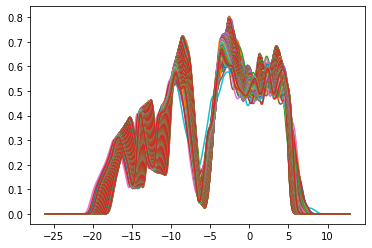

In [114]:
for i in range(0,324,1): #Diamond
    plt.plot(xdos, ldos[i])

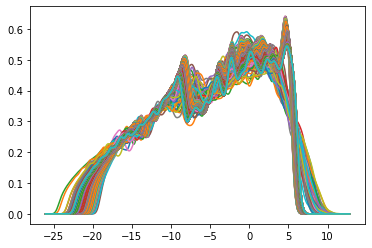

In [115]:
for i in range(324,604,1): #Beta tin
    plt.plot(xdos, ldos[i])

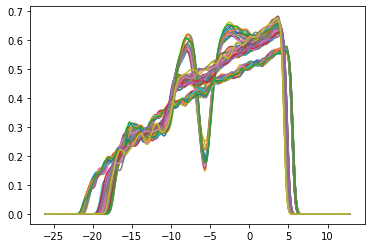

In [116]:
for i in range(604,673,1): #liquid
    plt.plot(xdos, ldos[i])

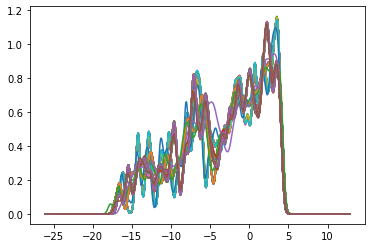

In [117]:
for i in range(673,939,1): #clusters
    plt.plot(xdos, ldos[i])

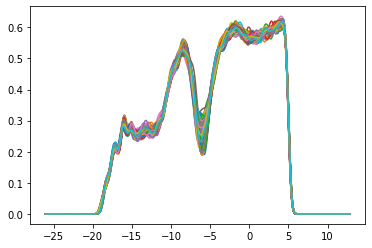

In [113]:
for i in range(939,1039,1): #amorphous
    plt.plot(xdos, ldos[i])

In [112]:
n_atoms[673:939]

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
       45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 46, 46, 46

In [90]:
bounds[0][0]

tensor(-71)

In [89]:
bounds[0][1]

tensor(121)

In [127]:
def t_get_mse(a, b, xdos = None, perc = False):
    if xdos is not None:
        mse = (torch.trapezoid((a - b)**2, xdos, axis=1)).mean()
        if not perc:
            return mse
        else:
            mean = b.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((b - mean)**2, xdos, axis=1)).mean()
            return (100 * mse / std)
    else:
        if len(a.size()) > 1:
            mse = ((a - b)**2).mean(dim = 1)
        else:
            mse = ((a - b)**2).mean()
        if len(mse.shape) > 1:
            raise ValueError('Loss became 2D')
        if not perc:
            return torch.mean(mse, 0)
        else:
            return torch.mean(100 * (mse / b.std(dim=0, unbiased = True)),0)


In [128]:
z.size()

torch.Size([778])

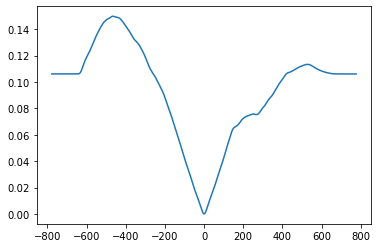

In [134]:
errs = []
z = ldos[400]
a = -778#bounds[0][0]
b = 778#bounds[0][1]
for j in range(a,b,1):
    targ = consistency.shifted_ldos(z, xdos, j*xdos_step)    

    errs.append(t_get_mse(z, targ))
    
plt.plot(np.arange(a,b), np.array(errs))

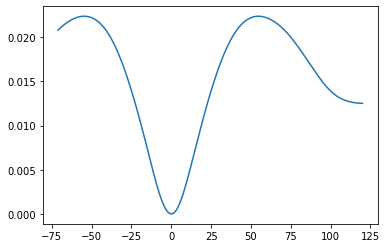

In [131]:
errs = []
for j in range(bounds[0][0],bounds[0][1],1):
    targ = consistency.shifted_ldos(y_pw[0], xdos, j*xdos_step)    
    errs.append(t_get_mse(y_pw[0], targ))
    
plt.plot(np.arange(bounds[0][0], bounds[0][1]), np.array(errs))

In [14]:
y_pw[0]



tensor([[-5.9823e-12, -1.4241e-11, -3.3019e-11,  ..., -1.2637e-11,
         -5.7103e-12, -2.5100e-12],
        [-5.9823e-12, -1.4241e-11, -3.3019e-11,  ..., -1.2637e-11,
         -5.7103e-12, -2.5100e-12],
        [-5.9823e-12, -1.4241e-11, -3.3019e-11,  ..., -1.2637e-11,
         -5.7103e-12, -2.5100e-12],
        ...,
        [-5.9823e-12, -1.4241e-11, -3.3019e-11,  ..., -1.2637e-11,
         -5.7103e-12, -2.5100e-12],
        [-5.9823e-12, -1.4241e-11, -3.3019e-11,  ..., -1.2637e-11,
         -5.7103e-12, -2.5100e-12],
        [-5.9823e-12, -1.4241e-11, -3.3019e-11,  ..., -1.2637e-11,
         -5.7103e-12, -2.5100e-12]])

In [126]:
generate_sample(bounds, ldos[train_index], 5)

(tensor([[  17,   90,   19,  ...,   26,   -7,  -35],
         [ 103,  -57,   -2,  ...,  -65,  -68,   21],
         [  68,  124,   19,  ...,   48, -102,   16],
         [  47,  117,   17,  ...,   96,  -32,   52],
         [ -28, -101,  -10,  ...,  -28,  -38,   22]]),
 tensor([0.0009, 0.0027, 0.0027, 0.0013, 0.0023]))

## Model

In [127]:
import dostools.src.models.models as models
import dostools.src.models.training as training
import dostools.src.models.architectures as architecture
import dostools.src.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)


class ShiftErrorModel(nn.Module):
    def __init__(self, inputSize, intermediateSize, outputSize):
        super(ShiftErrorModel, self).__init__()
        self.fc1 = nn.Linear(inputSize, intermediateSize, bias = True)
        self.fc2 = nn.Linear(intermediateSize, intermediateSize)
        self.fc3 = nn.Linear(intermediateSize,intermediateSize)
        self.fc4 = nn.Linear(intermediateSize, outputSize)
        self.silu = torch.nn.SiLU()

    def forward(self, x):
        """
        Performs the transformations to the features based on the model
        
        Args:
            x (tensor): input features
        
        Returns:
            tensor: output
        """
        out = self.fc1(x)
        out = self.silu(out)
        out = self.fc2(out)
        out = self.silu(out)
        out = self.fc3(out)
        out = self.silu(out)
        out = self.fc4(out)
        return out

 

In [128]:
model = ShiftErrorModel(831, 300, 1)

In [ ]:
lr = 0.001
batch_size = 16
n_epochs = 100000
weight_decay = 0

opt = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
threshold = 1000
scheduler_threshold = 100
tol = 1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
best_state = copy.deepcopy(model.state_dict())
lowest_loss = torch.tensor(9999)
pred_loss = torch.tensor(0)
trigger = 0
loss_history =[]
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    pbar.set_description(f"Epoch: {epoch}")
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)
    opt.zero_grad()
    x_data, y_data = generate_sample(bounds, ldos[train_index], batch_size)
    pred = model.forward(x_data.double())
    pred_loss = loss.t_get_mse(pred.view(-1,1), y_data.view(-1,1))#, self.xdos, perc = True)
    new_loss = pred_loss #*1E7
    new_loss.backward()
    opt.step()
    if pred_loss >100000 or (pred_loss.isnan().any()) :
        print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
        model.load_state_dict(best_state)
        opt = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    if epoch %1000 == 1:
        loss_history.append(lowest_loss.item())
    if lowest_loss - new_loss > tol: #threshold to stop training
        best_state = copy.deepcopy(model.state_dict())
        lowest_loss = new_loss
        trigger = 0
    else:
        trigger +=1

        if trigger > threshold:
            weight_decay.load_state_dict(best_state)
            for g in opt.param_groups:
                g['lr'] = lr
            batch_size = batch_size * 8
            print ("Increasing batch_size: {}".format(lowest_loss))


Epoch: 806:   1%|▊                                                                                                | 806/100000 [18:17:00<1910:26:00, 69.33s/it, lowest_loss=0.00173, pred_loss=0.00533, trigger=67]

## Dataset and DataLoader